In [1]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from collections import Counter
from sklearn.utils import shuffle
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import os
import sys
dir_store = os.path.join("..", "data")
sys.path.append(os.path.join( ".."))
from src.utils.store_utils import StorageHandler
store_handler = StorageHandler(dir_store=dir_store)

### Preprocessing data

In [2]:
data = store_handler.read("creditcard.csv")
features = [i for i in data if i not in ['Class']]
data["Time"] = data["Time"].diff()
data = data[~data["Time"].isnull()].reset_index(drop=True)





def undersample(input_data, target):
    min_occurence = min(Counter(list(input_data[target])).values())
    dfs = []
    sampled_indices = []
    for unique_target_value in input_data[target].unique():
        sampled_dataset = input_data[input_data[target] == unique_target_value].sample(min_occurence)
        sampled_indices += list(sampled_dataset.index)
        dfs.append(
            sampled_dataset
        )
    unsampled_data = input_data.loc[list(set(input_data.index) - set(sampled_indices))].reset_index(drop=True)
    return shuffle(pd.concat(dfs))

data = undersample(data, "Class")
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,...,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000
mean,0.879065,-2.367658,1.844612,-3.460841,2.276155,-1.645974,-0.694455,-2.806018,0.287569,-1.258399,...,0.346291,0.010844,-0.024126,-0.063654,0.002710,0.038811,0.072829,0.034210,103.307947,0.500000
std,1.591115,5.482054,3.625651,6.243056,3.168857,4.165071,1.720475,5.841561,4.869421,2.331853,...,2.786959,1.165244,1.192370,0.553015,0.674262,0.477482,1.007983,0.428620,228.873588,0.500254
min,0.000000,-30.552380,-8.402154,-31.103685,-3.132058,-22.105532,-6.406267,-43.557242,-41.044261,-13.434066,...,-22.797604,-8.887017,-19.254328,-2.224757,-4.781606,-1.256889,-7.263482,-3.147359,0.000000,0.000000
25%,0.000000,-2.784711,-0.159326,-5.078523,-0.023705,-1.793109,-1.559879,-3.078361,-0.204653,-2.302880,...,-0.155633,-0.513132,-0.233279,-0.401705,-0.328404,-0.270417,-0.068086,-0.061448,1.790000,0.000000
50%,0.000000,-0.848765,0.947118,-1.284266,1.270047,-0.471373,-0.657175,-0.689302,0.170406,-0.691590,...,0.137117,0.010306,-0.025394,-0.010730,0.035366,0.000308,0.046772,0.033333,19.020000,0.500000
75%,1.000000,1.021776,2.798885,0.389361,4.175332,0.402058,0.099819,0.226741,0.911253,0.255766,...,0.645756,0.586513,0.187053,0.356791,0.389081,0.340790,0.442424,0.220639,99.990000,1.000000
max,17.000000,2.308080,22.057729,3.265065,12.114672,11.095089,6.474115,7.280554,20.007208,5.072639,...,27.202839,8.361985,5.466230,3.054049,2.208209,2.745261,3.052358,1.779364,2125.870000,1.000000


### Hierarchical clustering

In [3]:
X = data[[i for i in data if i != 'Class']]
km = AgglomerativeClustering(n_clusters=2)
km = km.fit(X)

### Dimensionality reduction - Feature projection

In [4]:
X_embedded = TSNE(n_components=2, n_iter=2000, learning_rate=300, n_iter_without_progress=400).fit_transform(X)


C:\Users\mlioutas\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


### Visualize explanatory power

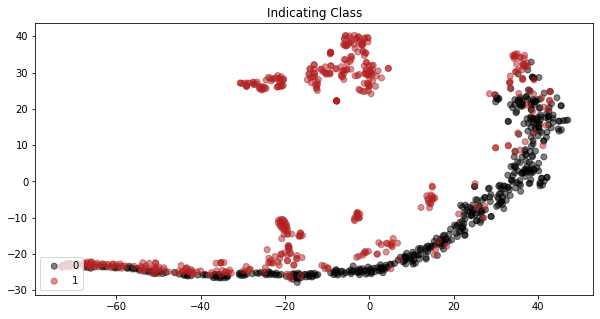

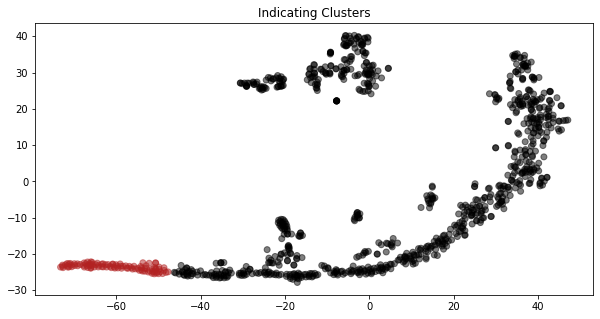

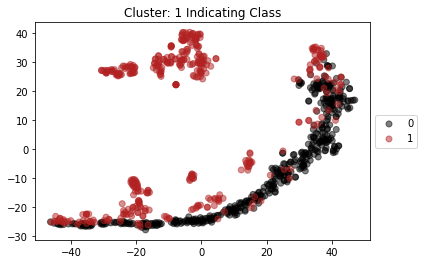

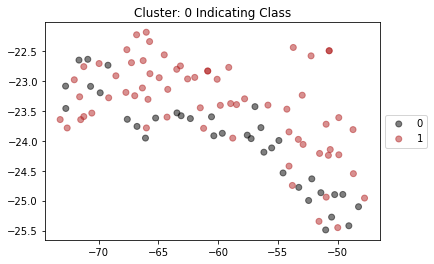

In [5]:
cluster_l = list(km.labels_)
data['cluster']=cluster_l
Y = data['Class']
categories = list(Y)
xx = [X_embedded[i][0] for i in range(len(X_embedded))]
yy = [X_embedded[i][1] for i in range(len(X_embedded))]

d = {'cluster': cluster_l, 'categories': categories, 'X': xx, 'Y': yy}
df = pd.DataFrame(data=d)

plt.figure(figsize=(10, 5))

colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgba(color)[:3])), name)
                for name, color in colors.items())
sorted_names = [name for hsv, name in by_hsv]

cats = list(df.categories.unique())
try:
    colors = {cats[i]: sorted_names[i * 20] for i in range(0, len(cats))}
except:
    colors = {cats[i]: sorted_names[i * 2] for i in range(0, len(cats))}
for cat in list(df.categories.unique()):
    df1 = df[df.categories == cat]
    plt.scatter(df1.X, df1.Y, c=df1.categories.map(colors), alpha=0.5, label=cat)
plt.legend(loc=3)
plt.title('Indicating Class')
plt.show()

plt.figure(figsize=(10, 5))
clusters = list(df.cluster.unique())
try:
    colors = {clusters[i]: sorted_names[i * 20] for i in range(0, len(clusters))}
except:
    colors = {clusters[i]: sorted_names[i * 2] for i in range(0, len(clusters))}
plt.scatter(df.X, df.Y, c=df.cluster.map(colors), alpha=0.5)
plt.title('Indicating Clusters')
plt.show()
try:
    colors = {cats[i]: sorted_names[i * 20] for i in range(0, len(cats))}
except:
    colors = {cats[i]: sorted_names[i * 2] for i in range(0, len(cats))}
for clust in clusters:
    df1 = df[df.cluster == clust]
    for cat in list(df.categories.unique()):
        df2 = df1[df1.categories == cat]
        if df2.empty:continue
        plt.scatter(df2.X, df2.Y, c=df2.categories.map(colors), alpha=0.5, label=cat)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Cluster: ' + str(clust) + ' Indicating Class')

    plt.show()